# Regression & Model Assessment


In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp
from jax.example_libraries import optimizers
import jax
# import dmol

# soldata = pd.read_csv('https://dataverse.harvard.edu/api/access/datafile/3407241?format=original&gbrecs=true')
soldata = pd.read_csv(
    "https://github.com/whitead/dmol-book/raw/master/data/curated-solubility-dataset.csv"
)
features_start_at = list(soldata.columns).index("MolWt")
feature_names = soldata.columns[features_start_at:]

## 1. Overfitting

We’ll be working again with the [AqSolDB dataset](https://www.nature.com/articles/s41597-019-0151-1). It has about 10,000 unique compounds with measured solubility in water (label) and 17 molecular descriptors (features). We need to create a better assessment of our supervised ML models. The goal of our ML model is to predict solubility of new unseen molecules. Therefore, to assess we should test on unseen molecules. We will split our data into two subsets: training data and testing data. Typically this is done with an 80%/20%, so that you train on 80% of your data and test on the remaining 20%. In our case, we’ll just do 50%/50% because we have plenty of data and thus do not need to take 80% for training. We’ll be using a subset, 50 molecules chosen randomly, rather than the whole dataset. So we’ll have 50 training molecules and 50 testing molecules.

Let’s begin by seeing what effect the split of train/test has on our linear model introduced in the previous chapter

In [33]:
# Get 50 points and split into train/test
sample = soldata.sample(50, replace=False)
train = sample[:25]
test = sample[25:]

# standardize the features using only train
test[feature_names] -= train[feature_names].mean()
test[feature_names] /= train[feature_names].std()
train[feature_names] -= train[feature_names].mean()
train[feature_names] /= train[feature_names].std()

# convert from pandas dataframe to numpy arrays
x = train[feature_names].values
y = train["Solubility"].values
test_x = test[feature_names].values
test_y = test["Solubility"].values

/home/eloi/.local/lib/python3.9/site-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


We will again use a linear model, $\hat{y} = \vec{w}\vec{x}+b$. One change we’ll make is using the `@jit` decorator from jax. This decorator will tell jax to inspect our function, simplify it, and compile it to run quickly on a GPU (if available) or CPU. The rest of our work is the same as the previous chapter. We begin with defining our loss, which is mean squared error (MSE) again.

In [34]:
# define our loss function
@jax.jit
def loss(w, b, x, y):
    return jnp.mean((y - jnp.dot(x, w) - b) ** 2)


loss_grad = jax.grad(loss, (0, 1))
w = np.random.normal(size=x.shape[1])
b = 0.0
loss_grad(w, b, x, y)

(DeviceArray([ 4.2509494 , -0.46628568,  4.4581947 ,  4.4264126 ,
               2.931987  , -1.8585246 ,  2.8848996 ,  0.34531304,
               4.163881  ,  5.587816  ,  1.9468755 ,  2.0883677 ,
               5.573721  ,  2.3055048 ,  4.3756843 , -3.1840134 ,
               4.8511705 ], dtype=float32),
 DeviceArray(4.623668, dtype=float32, weak_type=True))

Now we will train our model, again using gradient descent. This time we will not batch, since our training data only has 25 points. Can you see what the learning rate is? Why is it so different from the last chapter when we used the whole dataset?

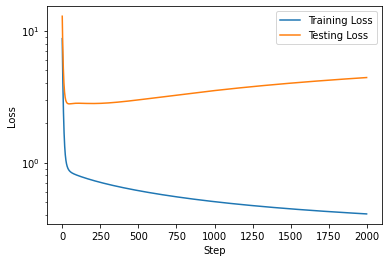

In [35]:
loss_progress = []
test_loss_progress = []
eta = 0.05
for i in range(2000):
    grad = loss_grad(w, b, x, y)
    w -= eta * grad[0]
    b -= eta * grad[1]
    loss_progress.append(loss(w, b, x, y))
    test_loss_progress.append(loss(w, b, test_x, test_y))
plt.plot(loss_progress, label="Training Loss")
plt.plot(test_loss_progress, label="Testing Loss")

plt.xlabel("Step")
plt.yscale("log")
plt.legend()
plt.ylabel("Loss")
plt.show()

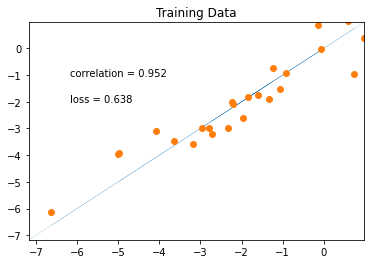

In [36]:
yhat = x @ w + b
plt.plot(y, y, ":", linewidth=0.2)
plt.plot(y, x @ w + b, "o")
plt.xlim(min(y), max(y))
plt.ylim(min(y), max(y))
plt.text(min(y) + 1, max(y) - 2, f"correlation = {np.corrcoef(y, yhat)[0,1]:.3f}")
plt.text(min(y) + 1, max(y) - 3, f"loss = {np.sqrt(np.mean((y - yhat)**2)):.3f}")
plt.title("Training Data")
plt.show()

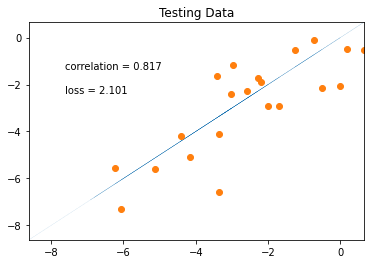

In [37]:
yhat = test_x @ w + b
plt.plot(test_y, test_y, ":", linewidth=0.2)
plt.plot(test_y, yhat, "o")
plt.xlim(min(test_y), max(test_y))
plt.ylim(min(test_y), max(test_y))
plt.text(
    min(test_y) + 1,
    max(test_y) - 2,
    f"correlation = {np.corrcoef(test_y, yhat)[0,1]:.3f}",
)
plt.text(
    min(test_y) + 1,
    max(test_y) - 3,
    f"loss = {np.sqrt(np.mean((test_y - yhat)**2)):.3f}",
)
plt.title("Testing Data")
plt.show()

We’ve plotted above the loss on our training data and testing data. The loss on training goes down after each step, as we would expect for gradient descent. However, the testing loss goes down and then starts to go back up. This is called overfitting. This is one of the key challenges in ML and we’ll often be discussing it.

Overfitting is a result of training for too many steps or with too many parameters, resulting in our model learning the noise in the training data. The noise is specific for the training data and when computing loss on the test data there is poor performance.

Datasets have a noise with mean 0 and unknown standard deviation that affect each entry. If we fit the model so much that it takes into account the arbitrary error in each entry it will affect negatively when using it to predict with new datasets that have different noise.

### 1.1. Overfitting with Synthetic Data

Our real function will be $f(x)=x^3 -x^2 +x -1 = \vec{w}·\vec{x}=[1,-1,1,-1]·[x^3,x^2,x,1]$ where our features are $[x^3,x^2,x,1]$. To do our split, we’ll take the positive points as training data and the negative as testing data. To avoid the issue of convergence, we will use least squares to fit these models instead of gradient descent.

Let’s establLet’s establish a benchmark. How well can a model do without noise? We’ll use 10 training data points and 10 testing data points. We’ll put our testing data in the center of the polynomial.ish a benchmark. How well can a model do without noise? We’ll use 10 training data points and 10 testing data points. We’ll put our testing data in the center of the polynomial.

In [38]:
# generate data from polynomial
N = 20
syn_x = np.linspace(-3, 3, N)
# create feature matrix
syn_features = np.vstack([syn_x**3, syn_x**2, syn_x, np.ones_like(syn_x)]).T
syn_labels = syn_x**3 - syn_x**2 + syn_x - 1

# print(syn_features)
# print(syn_labels)

/tmp/ipykernel_14358/4247135150.py:10: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  w, *_ = np.linalg.lstsq(train_x, train_y)


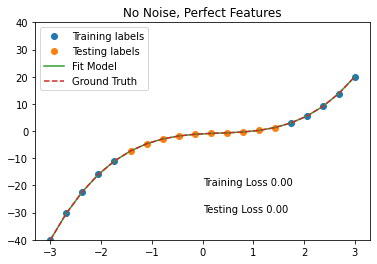

In [39]:
# split data into train/test
indices = list(range(0, N // 4)) + list(range(3 * N // 4, N))
test_indices = list(range(N // 4, 3 * N // 4))
train_x = syn_features[indices]
train_y = syn_labels[indices]
test_x = syn_features[test_indices]
test_y = syn_labels[test_indices]

# fit using numpy least squares method.
w, *_ = np.linalg.lstsq(train_x, train_y)

# plotting code
plt.plot(syn_x[indices], train_y, "o", label="Training labels")
plt.plot(syn_x[test_indices], test_y, "o", label="Testing labels")
plt.ylim(-40, 40)
plt.plot(syn_x, jnp.dot(syn_features, w), label="Fit Model")
plt.plot(syn_x, syn_labels, "--", label="Ground Truth")
plt.text(0, -20, f"Training Loss {loss(w,0,train_x, train_y):.2f}")
plt.text(0, -30, f"Testing Loss {loss(w,0, test_x, test_y):.2f}")
plt.legend()
plt.title("No Noise, Perfect Features")
plt.show()

There is no overfitting and the regression is quite accurate without noise. Now we’ll add noise to both the training labels

In [40]:
train_y = train_y + np.random.normal(scale=2, size=train_y.shape)

/tmp/ipykernel_14358/2494035002.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  w, *_ = np.linalg.lstsq(train_x, train_y)


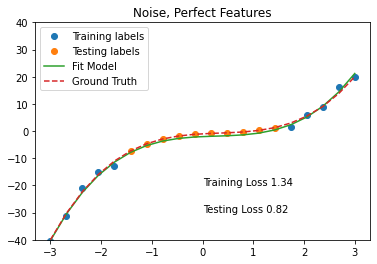

In [41]:
w, *_ = np.linalg.lstsq(train_x, train_y)
plt.plot(syn_x[indices], train_y, "o", label="Training labels")
plt.plot(syn_x[test_indices], test_y, "o", label="Testing labels")
plt.ylim(-40, 40)
plt.plot(syn_x, jnp.dot(syn_features, w), label="Fit Model")
plt.plot(syn_x, syn_labels, "--", label="Ground Truth")
plt.text(0, -20, f"Training Loss {loss(w,0,train_x, train_y):.2f}")
plt.text(0, -30, f"Testing Loss {loss(w,0, test_x, test_y):.2f}")
plt.legend()
plt.title("Noise, Perfect Features")
plt.show()

Now we’ll try adding redundant features. Our new features will be $[x^6,x^5,x^4,x^3,x^2,x,1]$. Still less than our data point number but not all features are necessary to fit the labels.

In [42]:
syn_features = np.vstack([syn_x**i for i in range(7)]).T

/tmp/ipykernel_14358/3756951946.py:5: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  w, *_ = np.linalg.lstsq(train_x, train_y)


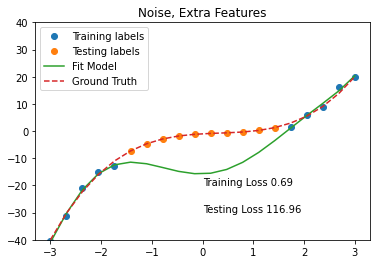

In [43]:
train_x = syn_features[indices]
test_x = syn_features[test_indices]
test_y = syn_labels[test_indices]

w, *_ = np.linalg.lstsq(train_x, train_y)
plt.plot(syn_x[indices], train_y, "o", label="Training labels")
plt.plot(syn_x[test_indices], test_y, "o", label="Testing labels")
plt.ylim(-40, 40)
plt.plot(syn_x, jnp.dot(syn_features, w), label="Fit Model")
plt.plot(syn_x, syn_labels, "--", label="Ground Truth")
plt.text(0, -20, f"Training Loss {loss(w,0,train_x, train_y):.2f}")
plt.text(0, -30, f"Testing Loss {loss(w,0, test_x, test_y):.2f}")
plt.legend(loc="upper left")
plt.title("Noise, Extra Features")
plt.show()

#### Overfitting conclusion

- Overfitting is inevitable in real data because we cannot avoid noise and rarely have the perfect features.
- Overfitting can be assessed by splitting our data into a train and test split, which mimics how we would use the model (i.e., on unseen data).
- Overfitting is especially affected by having too many features or features that don’t correlate well with the labels.
- We can identify overfitting from a loss curve which shows the testing loss rising while training loss is decreasing.


## 2. Exploring Effect of Feature Number

We’ve seen that overfitting is sensitive to the number and choice of features. Feature selection is a critical decision in supervised learning. We’ll return to the solubility dataset to discuss this. It has 17 molecular descriptors, but these are just a small fraction of the possible molecular descriptors that can be used. We’ll start this chapter by exploring what effect of number of features (dimension of features) has on the data.

We are now working with a real dataset, which means there is randomness from which features we choose, which training data we choose, and randomness in the labels themselves. In the results below, they are averaged over possible features and possible training data splits to deal with this. Thus the code is complex. You can see it on the [Github repository](https://github.com/whitead/dmol-book/blob/master/ml/regression.ipynb), but I’ve omitted it here for simplicity.

[See image](https://dmol.pub/_images/regression_37_0.png)

The figure shows the effect of choosing different features on both the loss on training data and the loss on test data. There are three regimes in this plot. At 1-3 features, we are underfit meaning both the training and testing losses could be improved with more features or more training. In this case, it is because there are too few features. Until about 10 features, we see that adding new features slightly improves training data but doesn’t help test data meaning we’re probably slightly overfitting. Then at 10, there is a large increase as we move to the overfit regime. Finally at about 30 features, our model is no longer converging and training loss rises because it is too difficult to train the increasingly complex model.

## 3. Bias Variance Decomposition

We will now try to be more systematic about this difference in model performance between training and testing data. Consider an unseen label $y$ and our model $\hat{f}(x)$. Our error on the unseen label is:

$$E\left[(y-\hat{f}(\vec{x}))^{2}\right]$$

For now, let’s just assume the only source of randomness is in the noise from the label which is given by $y=f(\vec{x}+\epsilon)$ where $f(\vec{x})$ is the function that we are finding and $\epsilon$ is the noise with mean 0 and standard deviation $\sigma$.
$$
E\left[(y-\hat{f}(\vec{x}))^{2}\right]=E\left[y^{2}\right]+E\left[\hat{f}(\vec{x})^{2}\right]-2 E[y \hat{f}(\vec{x})]
$$
$$
E\left[(y-\hat{f}(\vec{x}))^{2}\right]=E\left[(f(\vec{x})-\epsilon)^{2}\right]+\hat{f}(\vec{x})^{2}-2 E[f(\vec{x})-\epsilon] \hat{f}(\vec{x})
$$

Continuing we end up with
$$
E\left[(y-\hat{f}(\vec{x}))^{2}\right] = (f(\vec{x})-\hat{f}(\vec{x}))^{2}+E[\epsilon^2] = (f(\vec{x})-\hat{f}(\vec{x}))^{2}+E[\epsilon^2-0] = (f(\vec{x})-\hat{f}(\vec{x}))^{2}+\sigma^{2}
$$

This expression means the best we can do on an unseen label is the noise of the label. This is very reasonable, and probably matches your intuition. The best you can do is match exactly the noise in the label when you have a perfect agreement between $f(\vec{x})$ and $\hat{f}(\vec{x})$.

However, this analysis did not account for the fact our choice of training data is random. Things become more complex when we consider that our choice of training data is random. We must replace $\hat{f}(\vec{x})$ with $\hat{f}(\vec{x}, \mathbf{D})$ where $\mathbf{D}$ is a random variable indicating the random data sample. In the end, [the equation results in](https://en.wikipedia.org/wiki/Bias%E2%80%93variance_tradeoff#Derivation)
$$
E\left[(y-\hat{f}(\vec{x}))^{2}\right]=E[f(\vec{x})-\hat{f}(\vec{x} ; \mathbf{D})]^{2}+E\left[(E[\hat{f}(\vec{x} ; \mathbf{D})]-\hat{f}(\vec{x} ; \mathbf{D}))^{2}\right]+\sigma^{2}
$$

This expression is the most important equation for understanding ML and deep learning training. The first term in this expression is called bias and captures how far away our model is from the correct function.

The second term is surprising. It is called the variance and captures how much change at the unseen data point $(\vec{x},y)$ there is due to changes in the random variable $\mathbf{D}$. What is surprising is that the expected loss depends on the variance of the learned model. A model which is highly sensitive to which training data is chosen has a high expected error on test data.

These three terms: noise, bias, and variance set the minimum value for test error. Noise is set by your data and not controllable. However, bias and variance are controllable. What does a high bias, low variance model look like? A 1D linear model is a good example. [See Figure](https://dmol.pub/_images/regression_28_0.png). It has one parameter so a sample of data points gives a consistent estimate. However, a 1D model cannot capture the true $f(\vec{x})$ so it has a large average error (bias) at a given point. What does a low bias, high variance model look like? An overfit model like [see Figure](https://dmol.pub/_images/regression_29_0.png). It has extreme outliers on test data, but on average it actually has a low bias.

The way to change bias and variance is through model complexity, which is feature number in our linear models. Increasing model complexity reduces bias and increases variance. There is an optimum for our polynomial example, [see Figure](https://dmol.pub/_images/regression_30_0.png). Indeed this is true of most ML models, although it can be difficult to cleanly increase model complexity and keep training converged.